In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data preparation

In [4]:
import os
import re
import cv2
from pathlib import Path
DATA_PATH = '../../Dataset/trdg'

## Load the data

In [5]:
def create_dataset(img_paths):
    paths, labels, vocabs = [], [], []
    for path in img_paths:
        if os.path.getsize(path):
            label = re.sub('_.*', '', os.path.basename(path))
            paths.append(path)
            labels.append(label)
            vocabs.extend(list(label))
    return np.array(paths), np.array(labels), set(vocabs)

In [6]:
img_paths = list(map(str, Path(DATA_PATH).glob('*.jpg')))
img_paths, labels, vocabs = create_dataset(img_paths)

print('Number of training images:', len(img_paths))
print('Number of training labels:', len(labels))
print('Number of training vocabs:', len(vocabs))
print('Vocabularies in the training data:', vocabs)

Number of training images: 4434
Number of training labels: 4434
Number of training vocabs: 3291
Vocabularies in the training data: {'逵', '胤', '粉', '𬮎', '𠽐', '演', '堅', '礼', '郎', '悴', '舌', '腹', '財', '\U000f0820', '渃', '𠶣', '\U000f004d', '蝎', '湄', '當', '𧖱', '骸', '胣', '崙', '火', '針', '銃', '宗', '𢫝', '驚', '傑', '訢', '休', '模', '濯', '錢', '佛', '\U000f01f5', '謨', '黃', '蒸', '拮', '吀', '𫃫', '𢇡', '衝', '征', '\U000f12d4', '忝', '昌', '盈', '昂', '𫎇', '恃', '圖', '𢗼', '權', '河', '指', '㭳', '畫', '𢫔', '消', '洋', '𡘯', '𥒥', '棱', '滲', '傕', '\U000f0288', '芸', '脚', '野', '蕃', '䈟', '招', '痊', '𨒟', '回', '扡', '\U000f0811', '童', '𢴿', '册', '斎', '烝', '按', '健', '\U000f0152', '述', '墨', '盘', '金', '叁', '䠣', '猪', '詫', '𠻞', '涞', '臣', '准', '愚', '\U000f0e94', '少', '㘛', '䝨', '捕', '父', '𨱽', '滚', '幡', '帆', '鞋', '問', '分', '𣳮', '党', '𣲍', '登', '俘', '化', '𩅘', '捞', '唿', '当', '崇', '咳', '翁', '乘', '残', '四', '塞', '隐', '埬', '欺', '限', '毒', '㧅', '微', '耗', '澗', '轿', '𢝜', '蒲', '爲', '棟', '𣋽', '酌', '餞', '枝', '詐', '名', '羽', '𢬣', '\U000f07c0', '尾', '臺', '揨

## Dataset splitting

In [7]:
def split_data(img_paths, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(img_paths)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle: np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = img_paths[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = img_paths[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [8]:
x_train, x_valid, y_train, y_valid = split_data(img_paths, labels)
x_valid, x_test, y_valid, y_test = split_data(x_valid, y_valid, train_size=0.5)

print('Total training samples:', len(x_train))
print('Total validation samples:', len(x_valid))
print('Total testing samples:', len(x_test))

Total training samples: 3990
Total validation samples: 222
Total testing samples: 222


## Building the character vocabulary

In [9]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

## Preprocessing

In [10]:
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char_to_num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
HEIGHT = 148
WIDTH = 32

In [11]:
def distortion_free_resize(image, img_size):
    h, w = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top, pad_height_bottom = height + 1, height
    else: pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left, pad_width_right = width + 1, width
    else: pad_width_left = pad_width_right = pad_width // 2

    return tf.pad(image, paddings=[
        [pad_height_top, pad_height_bottom],
        [pad_width_left, pad_width_right],
        [0, 0],
    ], constant_values = 255) # Pad with white color

In [12]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

## Prepare `tf.data.Dataset` objects

In [13]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [14]:
train_tf_dataset = prepare_tf_dataset(x_train, y_train)
valid_tf_dataset = prepare_tf_dataset(x_valid, y_valid)
test_tf_dataset = prepare_tf_dataset(x_test, y_test)
train_tf_dataset

<PrefetchDataset shapes: {image: (None, None, None, 1), label: (None, None), label_length: (None,)}, types: {image: tf.float32, label: tf.int64, label_length: tf.int32}>

## Visualize the data

In [15]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import transforms

NROWS, NCOLS = (2, 8)
assert NROWS * NCOLS <= BATCH_SIZE, f'NROWS * NCOLS must be <= {BATCH_SIZE}'
FONT = fm.FontProperties(fname='../../Dataset/NomNaTong-Regular.ttf')

In [16]:
def visualize_batch(
    batch_images, batch_labels, pred_texts=None, 
    batch_size=BATCH_SIZE, nrows=NROWS, ncols=NCOLS
):
    plt.figure(figsize=(15, 7))
    for i in range(min(nrows * ncols, batch_size)):
        plt.subplot(nrows, ncols, i + 1)
        img = (batch_images[i] * 255.0).numpy().astype(np.uint8)
        plt.imshow(img[:, :, 0], cmap='gray')

        # Gather indices where label != padding_token.
        indices = tf.gather(
            batch_labels[i], 
            tf.where(tf.math.not_equal(batch_labels[i], PADDING_TOKEN))
        )
        label = tf.strings.reduce_join(num_to_char(indices)) # Convert to string
        label = label.numpy().decode('utf-8')
        
        text_x = WIDTH + 3
        fontdict = {
            'fontproperties': FONT,
            'fontsize': 18,
            'color': 'black',
            'verticalalignment': 'top',
            'horizontalalignment': 'left'
        }

        if pred_texts and pred_texts[i] != label: 
            for idx, char in enumerate(pred_texts[i]):
                text_y = idx * 18.5
                if char != label[idx]:
                    fontdict['color'] = 'black'
                    plt.text(text_x + 20, text_y, label[idx], fontdict=fontdict)
                    fontdict['color'] = 'red'
                else: 
                    fontdict['color'] = 'dodgerblue'
                plt.text(text_x, text_y, char, fontdict=fontdict)
        elif pred_texts and pred_texts[i] == label: 
            fontdict['color'] = 'green'
            plt.text(text_x, 0, '\n'.join(pred_texts[i]), fontdict=fontdict)
        else: 
            plt.text(text_x, 0, '\n'.join(label), fontdict=fontdict)
        plt.axis('off')

Image shape: (148, 32, 1)


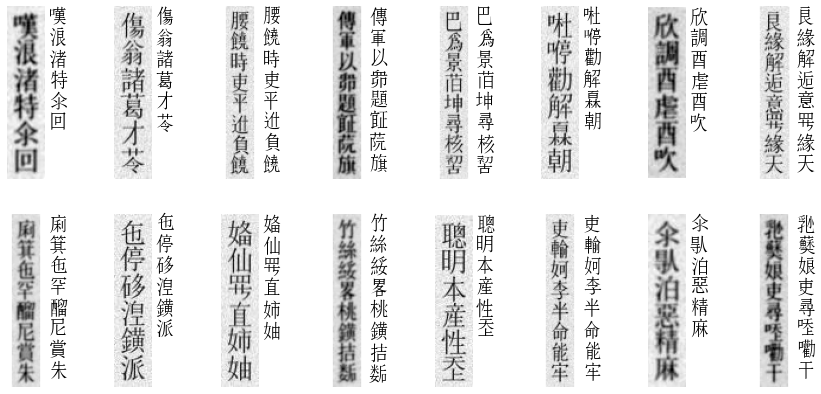

In [17]:
for batch in train_tf_dataset.take(1):
    batch_images, batch_labels = batch['image'], batch['label']
    visualize_batch(batch_images, batch_labels)

# Define the model

In [18]:
from tensorflow.keras.layers import (
    Input, BatchNormalization, LeakyReLU, Reshape,
    Conv2D, MaxPooling2D, Dense, Bidirectional, GRU
)
from tensorflow.keras.models import Model

## CTC Loss

In [19]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name='ctc_loss')
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, label_length):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        input_length *= tf.ones(shape=(batch_length, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred # At test time, just return the computed predictions.

## CRNN

In [20]:
def build_model(config, optimizer, name):
    image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int32', name='label_length')
    print(config)
    
    # Convolution layer with BatchNormalization and LeakyReLU activation
    def conv2D_bn(input_layer, filters, block_name, conv_idx):
        x = Conv2D(
            filters = filters, 
            kernel_size = (3, 3), 
            padding = 'same', 
            kernel_initializer = 'he_uniform',
            name = f'{block_name}_conv{conv_idx}'
        )(input_layer)
        x = BatchNormalization(name=f'{block_name}_bn{conv_idx}')(x)
        return LeakyReLU(alpha=0.2, name=f'{block_name}_activation{conv_idx}')(x)

    # Generate Convolutional blocks
    for idx, (block_name, block_config) in enumerate(config['conv_blocks'].items()):
        num_conv, filters = block_config
        for conv_idx in range(num_conv):
            input_layer = image_input if idx == 0 and conv_idx == 0 else x
            x = conv2D_bn(input_layer, filters, block_name, conv_idx + 1)
        x = MaxPooling2D(pool_size=(2, 2), name=f'{block_name}_pool')(x)

    # Reshape accordingly before passing the output to the RNN part
    _, height, width, channel = x.get_shape()
    x = Reshape(target_shape=(height, width * channel), name='reshape')(x)

    # RNN layers
    for idx in range(config['rnn_deep_num']):
        x = Bidirectional(GRU(
            units = 256, 
            return_sequences = True, 
            dropout = 0.2
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char_to_num.vocabulary_size() + 1, 
        activation = 'softmax', 
        name = 'RNN_output'
    )(x)
    
    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    model.compile(optimizer=optimizer)
    return model, Model(inputs=image_input, outputs=y_pred)

## Evaluation metric

In [21]:
validate_images = []
validate_labels = []
for batch in valid_tf_dataset:
    validate_images.append(batch['image'])
    validate_labels.append(batch['label'])

In [22]:
class EditDistanceCompute(tf.keras.callbacks.Callback):
    def __init__(self, prediction_model):
        self.prediction_model = prediction_model
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        for i in range(len(validate_images)):
            # Make predictions and convert them to sparse tensors.
            preds = self.prediction_model.predict(validate_images[i])
            preds_decoded = tf.keras.backend.ctc_decode(
                preds, 
                input_length = np.ones(preds.shape[0]) * preds.shape[1], 
                greedy = True
            )[0][0][:, :MAX_LENGTH]
            
            # Get a single batch and convert its labels to sparse tensors.
            sparse_labels = tf.sparse.from_dense(validate_labels[i])
            sparse_preds = tf.sparse.from_dense(preds_decoded)

            # Compute individual edit distances and average them out.
            edist = tf.edit_distance(
                tf.cast(sparse_preds, dtype='int64'), 
                tf.cast(sparse_labels, dtype='int64'), 
                normalize=False
            )
            edit_distances.append(tf.reduce_mean(edist).numpy())
            
        mean_edist = np.mean(edit_distances)
        self.logs.append(mean_edist)
        print(' - Mean edit distance:', mean_edist)

# Training

## Build the model

Generate Convolutional blocks and Bidirectional RNN layers by the following format:
```config = {
    'conv_blocks': {
        Name of the convolutional block: [
            Number of "conv2D_bn" layers,
            Number of filters for each "conv2D_bn" layer
        ]
    },
    'rnn_deep_num': Number of Bidirectional RNN layers
}```

In [23]:
from tensorflow.keras.optimizers import Adam
config = {
    'conv_blocks': {
        'bl1': [2, 64],  # block 1 with 2 "conv2D_bn" layers,  64 filters for each
        'bl2': [2, 128], # block 2 with 2 "conv2D_bn" layers, 128 filters for each
        'bl3': [2, 256], # block 3 with 2 "conv2D_bn" layers, 256 filters for each
    },
    'rnn_deep_num': 1 # Number of Bidirectional RNN layers
}
optimizer = Adam(learning_rate=2e-4)
model, prediction_model = build_model(config, optimizer, name='CRNN_OCR')
model.summary()                                

{'conv_blocks': {'bl1': [2, 64], 'bl2': [2, 128], 'bl3': [2, 256]}, 'rnn_deep_num': 1}
Model: "CRNN_OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 bl1_conv1 (Conv2D)             (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 bl1_bn1 (BatchNormalization)   (None, 148, 32, 64)  256         ['bl1_conv1[0][0]']              
                                                                                                  
 bl1

## Callbacks

In [24]:
from tensorflow.train import CheckpointOptions
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, 
    LearningRateScheduler, ReduceLROnPlateau
)

In [25]:
checkpoint_path = 'checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * len(x_train) // BATCH_SIZE, 
    options = options,  
    verbose = 1
)

In [26]:
# Keeps initial learning rate for first 3 epochs, decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 2: return lr
    return lr * tf.math.exp(-0.3)
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates => new_lr = lr * factor. 
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)

In [27]:
edit_distance_callback = EditDistanceCompute(prediction_model)        
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, # Stop if no improvement after 5 epochs
    min_delta = 0.0001, # The val_loss should at least improve 0.0001
    restore_best_weights = True, 
    verbose = 1
)

## `Model.fit` the CRNN 

In [28]:
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = 100,
    callbacks = [
#         checkpoint_callback,
#         schedule_lr_callback, 
        reduce_lr_callback, 
        edit_distance_callback, 
        early_stopping_callback,
    ],
    verbose = 1
)
model.save('crnn.h5')

Epoch 1/100
250/250 [==============================] - 13s 33ms/step - loss: 53.7597 - val_loss: 51.1276 - lr: 2.0000e-04
Epoch 2/100
250/250 [==============================] - 6s 24ms/step - loss: 50.3795 - val_loss: 49.8713 - lr: 2.0000e-04
Epoch 3/100
250/250 [==============================] - 6s 24ms/step - loss: 45.9239 - val_loss: 40.6718 - lr: 2.0000e-04
Epoch 4/100
250/250 [==============================] - 6s 24ms/step - loss: 31.9948 - val_loss: 26.2921 - lr: 2.0000e-04
Epoch 5/100
250/250 [==============================] - 6s 24ms/step - loss: 21.1574 - val_loss: 18.7942 - lr: 2.0000e-04
Epoch 6/100
250/250 [==============================] - 6s 24ms/step - loss: 14.7546 - val_loss: 14.3514 - lr: 2.0000e-04
Epoch 7/100
250/250 [==============================] - 6s 24ms/step - loss: 10.6539 - val_loss: 11.6753 - lr: 2.0000e-04
Epoch 8/100
250/250 [==============================] - 6s 24ms/step - loss: 7.8717 - val_loss: 10.2031 - lr: 2.0000e-04
Epoch 9/100
250/250 [===========

## Visualize training result

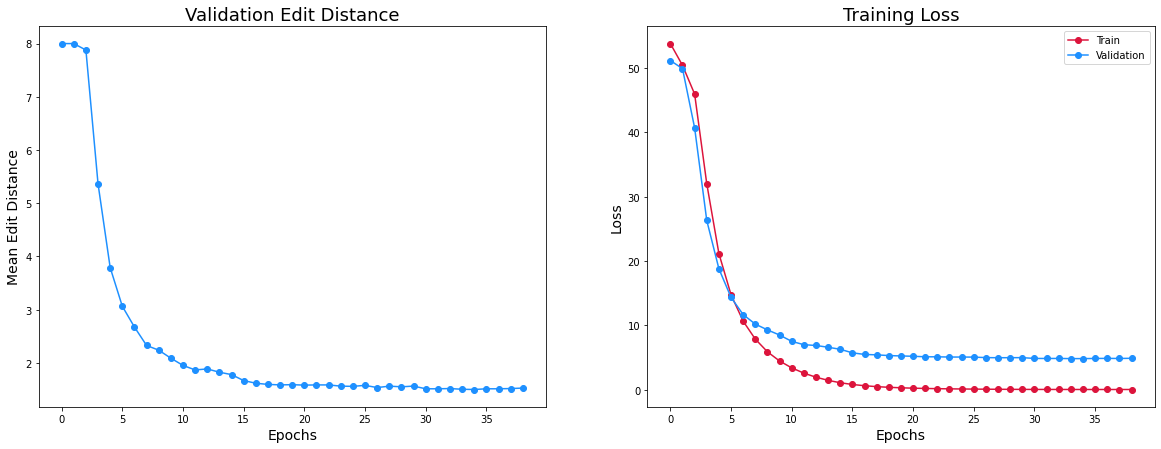

In [60]:
fig = plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
plt.plot(edit_distance_callback.logs, linestyle='solid', marker='o', color='dodgerblue')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Mean Edit Distance',fontsize=14)
plt.title('Validation Edit Distance', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Training Loss', fontsize=18)
plt.legend(loc='best')

fig.savefig('crnn_history.png', bbox_inches='tight') 
plt.show()

# Inference

In [121]:
# A utility function to decode the output of the network
def decode_batch_predictions(preds):
    # Use greedy search. For complex tasks, you can use beam search
    preds_decoded = tf.keras.backend.ctc_decode(
        preds, 
        input_length = np.ones(preds.shape[0]) * preds.shape[1], 
        greedy = True
    )[0][0][:, :MAX_LENGTH]
    
    # Iterate over the results and get back the text
    output_text = []
    for result in preds_decoded:
        result = tf.gather(result, tf.where(tf.math.not_equal(result, -1)))
        result = tf.strings.reduce_join(num_to_char(result))
        output_text.append(result.numpy().decode('utf-8'))
    return output_text

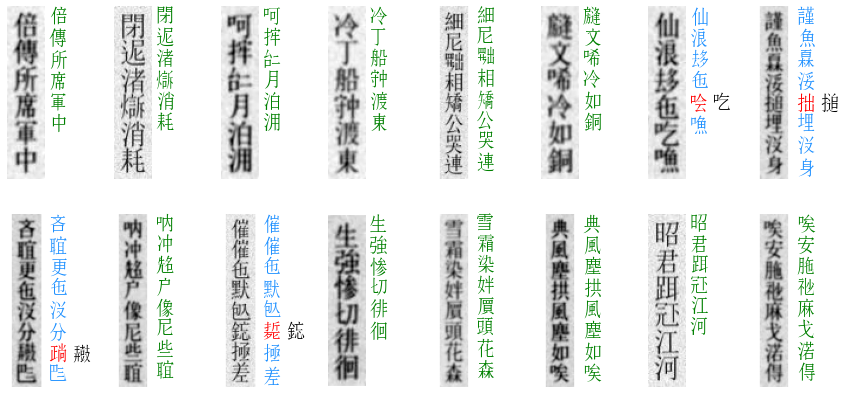

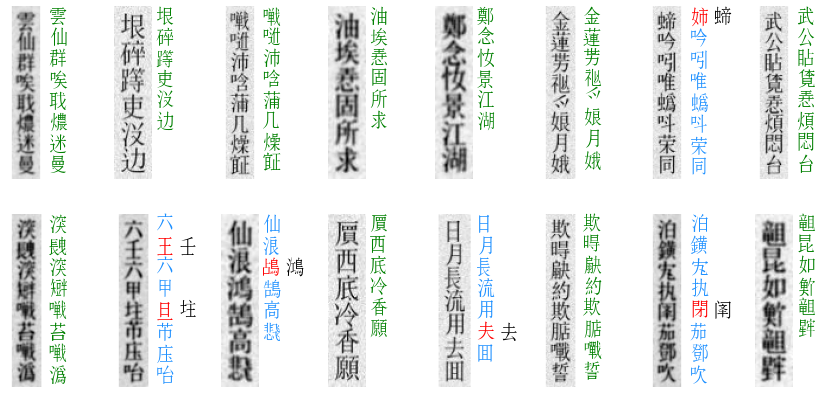

In [122]:
for batch in test_tf_dataset.take(2):
    batch_images, batch_labels = batch['image'], batch['label']
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    visualize_batch(batch_images, batch_labels, pred_texts)